# Migrating point load with Te Change

In [71]:
from __future__ import print_function

import numpy as np
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib

import time
#import pylab as plt
from IPython import display

import imageio

%load_ext autoreload
%autoreload 1
%aimport flexureCodeForTeChange
%aimport makeAnimGif

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
## Constants...

g = 9.8 #ms-2
nu = 0.25
E = 7e10

In [74]:
# OPTION 1: Use this option to set strength using elastic thicknesses

Te_1 = 30000
D_1 = Te_1**4 * E / (12 * (1-nu**2) ) 

Te_2 = 10000
D_2 = Te_2**4 * E / (12 * (1-nu**2) ) 

In [75]:
## OPTION 2: Use this to set strength using D

D_2 = 4.6e22 #flexural regidity (N meters), weak plate
D_1 = 3.7e23 #flexural regidity (N meters), strong plate

Te_1 = np.round( np.cbrt(12*(1-nu**2)*D_1/E), 0)
Te_2 = np.round( np.cbrt(12*(1-nu**2)*D_2/E), 0)

In [104]:
#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3

rho_i = rho_s

h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_i)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_i)))**0.25

n_halfWidth = 700000

V_0 = 8.8e12

# Scale the load to height
orogenWidth = 100   # [km]
loadPerKm = V_0 / orogenWidth
orogenHeight = loadPerKm / (g * rho_s)
print("For a "+ str(orogenWidth) +" km wide orogen, the height is "+str(np.round(orogenHeight))+' km')

# Specify as a point load
contact_load = np.array( [V_0] )

# Since the model uses Te change as x=0, 
# we need to specify the loaction of the load in time to model convergence
loadLocations = n_halfWidth + np.arange(-600000, 250000, 1000)

For a 100 km wide orogen, the height is 2993197.0 km


In [105]:
# Calculate the initial and final profiles to specify initial and endmember models

x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_2, a_2, D_2, D_2, contact_load, n_load, n_halfWidth)

z_min = np.min(w)
z_min = np.round(z_min, -2)-100

z_max = np.max(w)
z_max = np.round(z_max, -2)+300

x_min = -100
x_max = np.round(4*a_1/1000., -2)

print(x_max)

600.0


In [95]:
print(Te_1, Te_2)

39032.0 19481.0


In [111]:
outputFilename = "PointLoad-"+"Te1_"+str(int(Te_1/1000))+"-Te2_"+str(int(Te_2/1000))+"-rhoInfill_"+str(rho_i)+"-V0_"+str(V_0).replace('.','p')

In [96]:
matplotlib.interactive(False)

In [97]:
z_FB = np.zeros_like( loadLocations )
z_DF = np.zeros_like( loadLocations )
z_deepest = np.zeros_like( loadLocations )

x_FB = np.zeros_like( loadLocations )
x_DF = np.zeros_like( loadLocations )
x_BM = np.zeros_like( loadLocations )
x_deepest = np.zeros_like( loadLocations )

basinWidth_DF2FB = np.zeros_like( loadLocations )
basinWidth_DF2BM = np.zeros_like( loadLocations )
basinWidth_DF2Deepest = np.zeros_like( loadLocations )

t_list = np.array([0])

plotFigs=True

if(plotFigs == True):
    filename_list=[]

print("Getting uniform initial and final states")
V_0 = contact_load[0]

t = -1
load_points = loadLocations[t]

n_load = np.array( [load_points] )
x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_1, a_1, D_1, D_1, contact_load, n_load, n_halfWidth)
initial_w = w
initial_x = x - x[load_points]

x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_2, a_2, D_2, D_2, contact_load, n_load, n_halfWidth)
final_w = w
final_x = x - x[load_points]

print("Running temporal model")
for t in range(0,len(loadLocations),1):
    if(t>1):
        t_list = np.append(t_list, t)
    load_points = loadLocations[t]
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)

    Te = np.copy(x)
    n_Low = Te[Te<0]
    n_High = Te[Te>=0]

    n_FB = n_load + np.argmax( w[ load_points : ] )
    n_BM = n_load + np.argmin( w[ load_points : n_FB[0]]*w[ load_points :n_FB[0] ] )
    n_deepest = np.argmin(w)
    
    x_BM[t] = x[n_BM] - x[load_points]
    x_FB[t] = x[n_FB] - x[load_points]
    x_DF[t] = x[load_points]
    x_deepest[t] = x[n_deepest] - x[load_points]
    
    z_FB[t] = w[ n_FB ]
    z_DF[t] = w[load_points]
    z_deepest[t] = w[n_deepest]
    
    basinWidth_DF2FB[t] = x[n_FB] - x[load_points]
    basinWidth_DF2BM[t] = x[n_BM] - x[load_points]
    basinWidth_DF2Deepest[t] = x[n_deepest] - x[load_points]
    
    if(plotFigs == True):
        filename = "tmpFigs/tmp_"+str(t)+".png"
        
        filename_list.append(filename)
        print(filename, end='\r')
        
        plt.figure(figsize=(14,7))
        
        plt.plot(initial_x/1000, initial_w, linestyle=":", linewidth=0.5, label="Initial profile" )
        plt.plot(final_x/1000, final_w, linestyle=":", linewidth=0.5, label="Final profile" )

        plt.plot((x[n_Low]-x[load_points])/1000, w[n_Low], label="Weak plate $T_e$ = "+str(Te_2) )
        plt.plot((x[n_High]-x[load_points])/1000, w[n_High], label="Strong plate $T_e$ = "+str(Te_1) )

        plt.plot(x_FB[t_list]/1000, z_FB[t_list], label="Translation of forebulge", linestyle="--")
        plt.plot(x_BM[t_list]/1000, np.zeros_like(x_BM[t_list]), label="Translation of basin margin", linestyle="--")
        plt.plot(x_deepest[t_list]/1000, z_deepest[t_list], label="Translation of deepest point", linestyle="--")

        plt.axvline(x=0,linestyle=':')
        plt.axhline(y=0,linestyle=':')
        plt.ylabel("Slab evevation [m]")
        plt.xlabel("Location relative to deformation front [km]")
        plt.xlim(x_min, x_max)
        plt.ylim(z_min, z_max)
        TeRatio = np.round(Te_2/Te_1,2)
        plt.title( "Point Load at $x=0$    Time = "+str(t)+"   Te Ratio = "+ str(TeRatio) )
        plt.legend(loc='lower right')
        plt.savefig(filename)
        plt.close('all')

if(plotFigs == True):
    print("Making animated GIF")
    pwd = "/Users/mnaylor/OneDrive - University of Edinburgh/MyProjects/agata"
    movieFilename = "Movie_"+outputFilename+".gif"
    makeAnimGif.makeAnim(filename_list, pwd, outputFile=movieFilename)

Getting initial and final states
Running temporal model
Making animated GIF


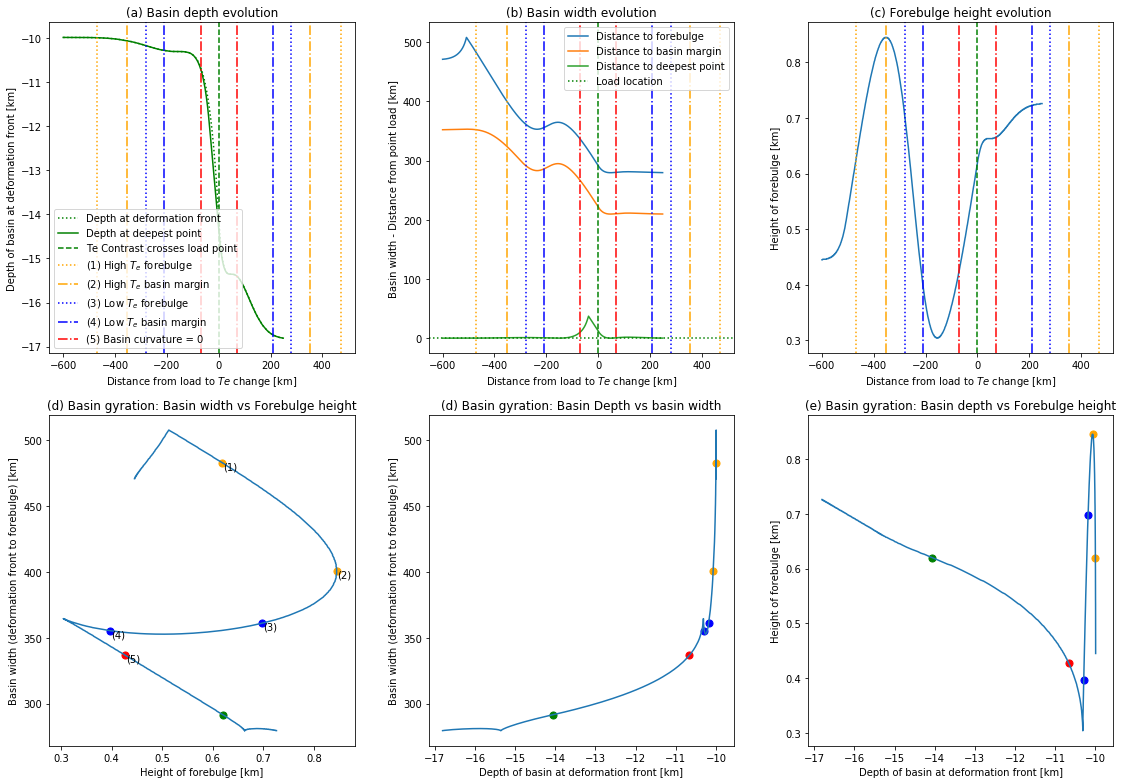

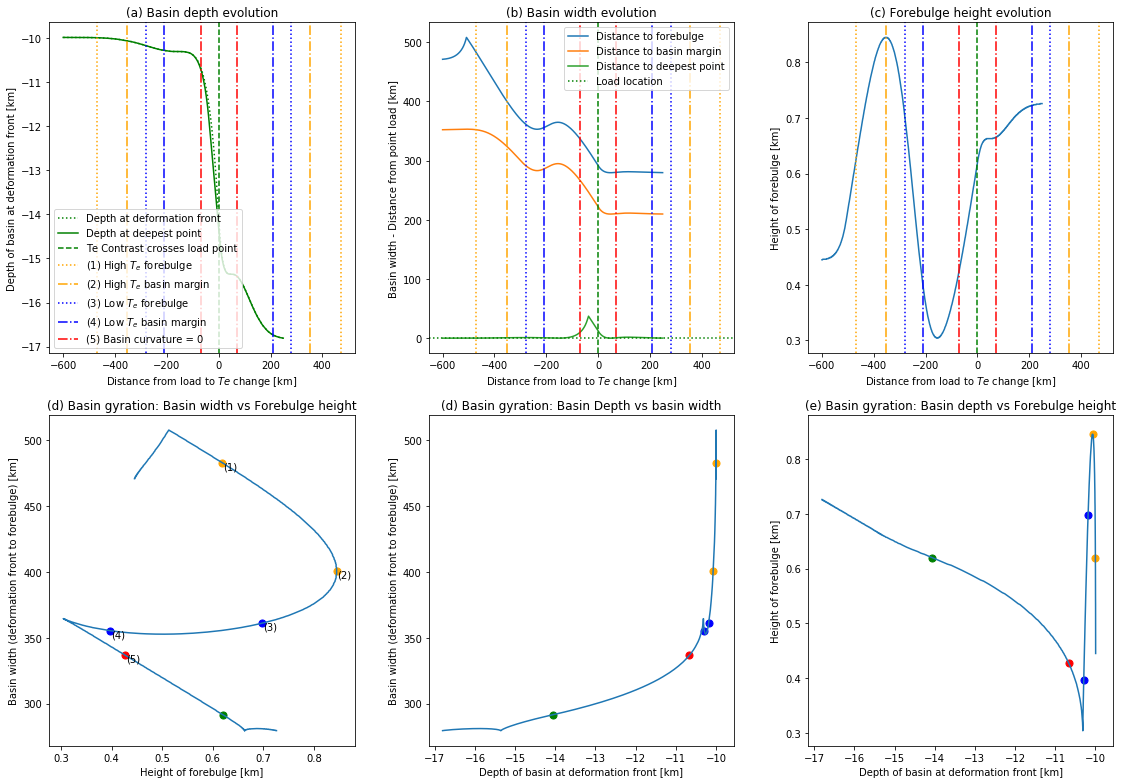

In [112]:
### PAPER FIGURE

plt.figure(figsize=(16,11))

a_high = np.max( [a_1,a_2] )
a_low = np.min( [a_1,a_2] )

n_TeCrossingDF = (loadLocations-n_halfWidth)==0
x_forebulge_low = np.pi*a_low
x_forebulge_high = np.pi*a_high
x_BM_low = 3*np.pi/4*a_low
x_BM_high = 3*np.pi/4*a_high
x_StressChange_high = np.pi/4*a_high
x_StressChange_low = np.pi/4*a_low

n_forebulge_low = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_low)**2)
n_forebulge_high = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_high)**2)
n_BM_low = np.argmin( ((loadLocations-n_halfWidth)+x_BM_low)**2)
n_BM_high = np.argmin( ((loadLocations-n_halfWidth)+x_BM_high)**2)
n_StressChange_high = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_high)**2)
n_StressChange_low = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_low)**2)


plt.subplot(2,3,3)
plt.plot((loadLocations-n_halfWidth)/1000., z_FB/1000.)
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(c) Forebulge height evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.subplot(2,3,1)
plt.plot((loadLocations-n_halfWidth)/1000., z_DF/1000., label="Depth at deformation front", c='g', linestyle=":")
plt.plot((loadLocations-n_halfWidth)/1000., z_deepest/1000., label="Depth at deepest point", c='g', linestyle="-")

plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Depth of basin at deformation front [km]")
plt.title("(a) Basin depth evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) Low $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.legend(loc="lower left")

plt.subplot(2,3,2)
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2FB/1000., label="Distance to forebulge")
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2BM/1000., label="Distance to basin margin")
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2Deepest/1000., label="Distance to deepest point")
plt.axhline(y=0, label="Load location", linestyle=":",c='g')
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Basin width - Distance from point load [km]")
plt.title("(b) Basin width evolution")

plt.axvline(0, c='g', linestyle="--")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.legend()



plt.subplot(2,3,4)
plt.plot( z_FB/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_FB[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Height of forebulge [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(d) Basin gyration: Basin width vs Forebulge height")

n = ["(1)", "(2)","(3)","(4)","(5)"]
xs = [z_FB[n_forebulge_high]/1000., z_FB[n_BM_high]/1000., z_FB[n_forebulge_low]/1000., z_FB[n_BM_low]/1000., z_FB[n_StressChange_low]/1000. ]
ys = [basinWidth_DF2FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_BM_high]/1000.,basinWidth_DF2FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_BM_low]/1000.,  basinWidth_DF2FB[n_StressChange_low]/1000.]

for i, txt in enumerate(n):
    plt.annotate(txt, (xs[i], ys[i]), xytext=(xs[i]+0.001,ys[i]-5))


plt.scatter(z_FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_FB[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_FB[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)


plt.subplot(2,3,5)
plt.plot( z_DF/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(d) Basin gyration: Basin Depth vs basin width")


plt.scatter(z_DF[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)



plt.subplot(2,3,6)
plt.plot( z_DF/1000., z_FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., z_FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(e) Basin gyration: Basin depth vs Forebulge height")


plt.scatter(z_DF[n_forebulge_low]/1000., z_FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., z_FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., z_FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., z_FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., z_FB[n_StressChange_low]/1000., c="r", s=50)

plt.tight_layout()

metricFigureFilename = "BasinMetricFigure_"+outputFilename+".png"
plt.savefig(metricFigureFilename)
plt.show()